In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Annotations/"


my_train  my_val  total  train	train_aug  val


Load libraries

In [ ]:
!pip install pytorchvideo --quiet
!pip install av --quiet  # required by pytorchvideo


In [ ]:
!pip install "git+https://github.com/facebookresearch/pytorchvideo.git"

  Cloning https://github.com/facebookresearch/pytorchvideo.git to /tmp/pip-req-build-nvcm_yrs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo.git /tmp/pip-req-build-nvcm_yrs
  Resolved https://github.com/facebookresearch/pytorchvideo.git to commit 6cdc929315aab1b5674b6dcf73b16ec99147735f
  Preparing metadata (setup.py) ... done


In [ ]:
import torch
import torch.nn as nn
from pytorchvideo.models.hub import slowfast_r50

Load Data

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import os
import cv2
import torchvision.transforms as T

class VideoDataset(Dataset):
    def __init__(self, root_dir, clip_len=32, image_size=224):
        self.root_dir = root_dir
        self.clip_len = clip_len
        self.image_size = image_size
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.samples = []

        for cls in self.classes:
            class_path = os.path.join(root_dir, cls)
            # Skip non-class folders
            if not os.path.isdir(class_path):
                continue
            for f in os.listdir(class_path):
                if f.endswith(".mp4"):
                    self.samples.append((os.path.join(class_path, f), self.class_to_idx[cls]))

        self.transform = T.Compose([
            T.ToPILImage(),
            T.Resize((image_size, image_size)),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        cap = cv2.VideoCapture(path)
        frames = []

        while len(frames) < self.clip_len:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = self.transform(frame)
            frames.append(frame)

        cap.release()

        # If no frames were read or not enough frames, return a dummy tensor and skip printing the warning
        if len(frames) == 0 or len(frames) < self.clip_len:
            # print(f" Skipping video (no frames or not enough frames): {path}") # Commented out to reduce output
            dummy = torch.zeros(3, self.clip_len, self.image_size, self.image_size)
            return dummy, label

        video = torch.stack(frames[:self.clip_len], dim=1)  # [C, T, H, W]
        return video, label

In [ ]:
def pack_pathway_output(frames, alpha=4):
    """
    frames: [B, C, T, H, W]
    returns: [slow_pathway, fast_pathway]
    """
    fast = frames
    T = frames.shape[2]
    # sample every alpha-th frame along TIME
    idx = torch.arange(0, T, step=alpha, device=frames.device)
    if idx.numel() == 0:  # safety if T < alpha
        idx = torch.tensor([0], device=frames.device)
    slow = torch.index_select(frames, dim=2, index=idx)
    return [slow, fast]


In [ ]:
from torch.utils.data import Dataset, DataLoader
train_dataset = VideoDataset("/content/drive/MyDrive/Annotations/train")
val_dataset = VideoDataset("/content/drive/MyDrive/Annotations/val")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = slowfast_r50(pretrained=True)
model.blocks[-1].proj = nn.Linear(model.blocks[-1].proj.in_features, 7)  # 7 classes
model = model.to(device)


Training

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for videos, labels in train_loader:
        # Skip batches with dummy tensors (videos with no frames or not enough frames)
        if torch.all(videos == 0):
            continue

        videos, labels = videos.to(device), labels.to(device)
        inputs = pack_pathway_output(videos)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1}: Loss = {total_loss:.4f}, Train Accuracy = {100 * correct / total:.2f}%")

Epoch 1: Loss = 746.1863, Train Accuracy = 66.98%
Epoch 2: Loss = 398.8866, Train Accuracy = 83.94%
Epoch 3: Loss = 262.1044, Train Accuracy = 89.62%
Epoch 4: Loss = 170.2243, Train Accuracy = 93.06%
Epoch 5: Loss = 129.6421, Train Accuracy = 94.80%
Epoch 6: Loss = 95.3692, Train Accuracy = 96.47%
Epoch 7: Loss = 101.2557, Train Accuracy = 96.41%
Epoch 8: Loss = 71.2157, Train Accuracy = 97.22%
Epoch 9: Loss = 73.8401, Train Accuracy = 97.28%
Epoch 10: Loss = 56.0401, Train Accuracy = 97.94%


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

model.eval()
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for vids, labels in val_loader:
        vids = vids.to(device); labels = labels.to(device)
        slow, fast = pack_pathway_output(vids)
        logits = model([slow, fast])              # [B, num_classes]
        probs = F.softmax(logits, dim=1)          # [B, num_classes]
        preds = logits.argmax(1)

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)   # shape [N, num_classes]
num_classes = all_probs.shape[1]
class_names = val_loader.dataset.classes  # sorted folder names


Save Results

In [ ]:
import os, time, json
import numpy as np
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report

RUN_NAME = time.strftime("slowfast_eval_%Y%m%d_%H%M%S")
OUT_DIR = Path(f"/content/drive/MyDrive/SlowFastResults1/{RUN_NAME}")
OUT_DIR.mkdir(parents=True, exist_ok=True)

cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
report_txt = classification_report(all_labels, all_preds, target_names=class_names, digits=4)

np.save(OUT_DIR / "confusion_matrix.npy", cm)
with open(OUT_DIR / "classification_report.txt", "w") as f:
    f.write(report_txt)

print(report_txt)
print("Saved:", OUT_DIR / "confusion_matrix.npy", "and", OUT_DIR / "classification_report.txt")


                       precision    recall  f1-score   support

             Drinking     0.8873    0.7975    0.8400        79
      Feeding & Lying     0.8684    0.7500    0.8049        44
   Feeding & Standing     0.9101    0.9036    0.9068       280
                Lying     0.8847    0.9219    0.9029       333
   Ruminating & Lying     0.8333    0.8197    0.8264       183
Ruminating & Standing     0.7901    0.6337    0.7033       101
             Standing     0.6290    0.7879    0.6996        99

             accuracy                         0.8472      1119
            macro avg     0.8290    0.8020    0.8120      1119
         weighted avg     0.8510    0.8472    0.8471      1119

Saved: /content/drive/MyDrive/SlowFastResults1/slowfast_eval_20251024_045004/confusion_matrix.npy and /content/drive/MyDrive/SlowFastResults1/slowfast_eval_20251024_045004/classification_report.txt


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_cm(cm, classes, title, normalize=False, save_path=None):
    """
    cm: confusion matrix (ndarray)
    classes: list of class names
    normalize: if True, rows sum to 1.0
    """
    if normalize:
        M = cm.astype(np.float64)
        row_sums = M.sum(axis=1, keepdims=True)
        M = np.divide(M, row_sums, out=np.zeros_like(M, dtype=np.float64), where=row_sums!=0)
        fmt = ".2f"
    else:
        M = cm
        fmt = "d"

    plt.figure(figsize=(8, 7))
    plt.imshow(M, interpolation="nearest", cmap=plt.cm.Blues)  # blue colormap
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha="right")
    plt.yticks(tick_marks, classes)

    thresh = np.nanmax(M) / 2.0 if M.size else 0.5
    for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
        val = M[i, j]
        text_val = format(val, fmt) if normalize else str(int(val))
        plt.text(j, i, text_val,
                 ha="center", va="center",
                 color="white" if val > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


                       precision    recall  f1-score   support

             Drinking     0.8873    0.7975    0.8400        79
      Feeding & Lying     0.8684    0.7500    0.8049        44
   Feeding & Standing     0.9101    0.9036    0.9068       280
                Lying     0.8847    0.9219    0.9029       333
   Ruminating & Lying     0.8333    0.8197    0.8264       183
Ruminating & Standing     0.7901    0.6337    0.7033       101
             Standing     0.6290    0.7879    0.6996        99

             accuracy                         0.8472      1119
            macro avg     0.8290    0.8020    0.8120      1119
         weighted avg     0.8510    0.8472    0.8471      1119



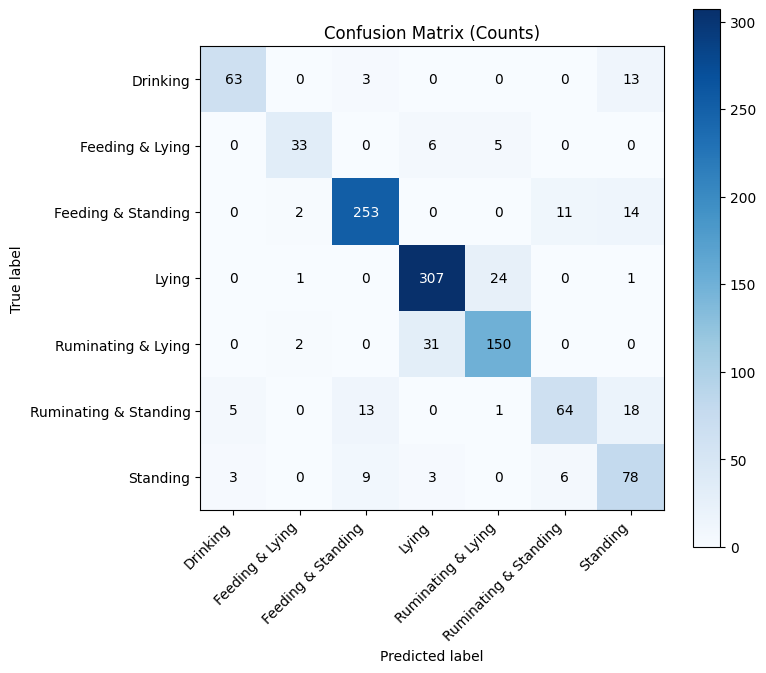

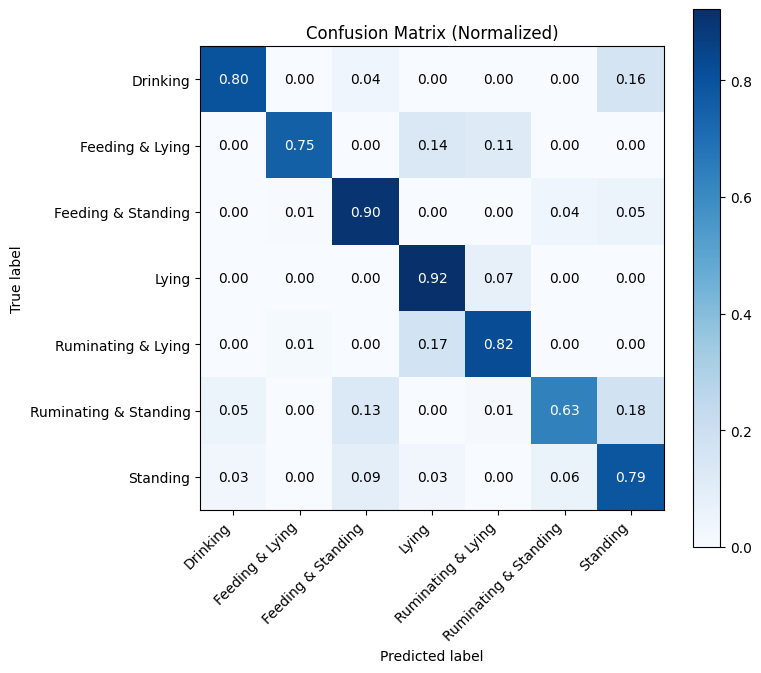


Saved to: /content/drive/MyDrive/SlowFastResults1/slowfast_eval_20251024_045151
 - confusion_matrix_counts.png
 - confusion_matrix_normalized.png
 - confusion_matrix.npy
 - classification_report.txt
 - slowfast_7class_state_dict.pth
 - metadata.json


In [ ]:
# prereqs this cell assumes
# - model, val_loader, device already defined
# - pack_pathway_output(frames, alpha=4) indexes along TIME (dim=2) and uses arange
# - matplotlib already available

import time, json, itertools
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ---------------------------
#  Eval on validation set
# ---------------------------
model.eval()
all_labels, all_preds, all_probs = [], [], []

with torch.no_grad():
    for vids, labels in val_loader:
        vids = vids.to(device); labels = labels.to(device)
        slow, fast = pack_pathway_output(vids)
        logits = model([slow, fast])                # [B, C]
        probs  = F.softmax(logits, dim=1)           # [B, C]
        preds  = logits.argmax(1)

        all_labels.extend(labels.cpu().numpy().tolist())
        all_preds.extend(preds.cpu().numpy().tolist())
        all_probs.extend(probs.cpu().numpy().tolist())

all_labels = np.array(all_labels)
all_preds  = np.array(all_preds)
all_probs  = np.array(all_probs)
class_names = val_loader.dataset.classes
num_classes = len(class_names)

# ---------------------------
# Confusion matrix + report
# ---------------------------
cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
report_txt = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print(report_txt)

# ---------------------------
# Blue confusion-matrix plotter
# ---------------------------
def plot_cm(cm, classes, title, normalize=False, save_path=None):
    """
    Blue confusion matrix. If normalize=True, rows sum to 1.0.
    """
    if normalize:
        M = cm.astype(np.float64)
        row_sums = M.sum(axis=1, keepdims=True)
        M = np.divide(M, row_sums, out=np.zeros_like(M, dtype=np.float64), where=row_sums!=0)
        fmt = ".2f"
    else:
        M = cm  # keep counts as ints for labeling
        fmt = "d"

    plt.figure(figsize=(8, 7))
    plt.imshow(M, interpolation="nearest", cmap=plt.cm.Blues)  # << the regular blue one
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(len(classes))
    plt.xticks(ticks, classes, rotation=45, ha="right")
    plt.yticks(ticks, classes)

    thresh = np.nanmax(M) / 2.0 if M.size else 0.5
    for i, j in itertools.product(range(M.shape[0]), range(M.shape[1])):
        val = M[i, j]
        text_val = format(val, fmt) if normalize else str(int(val))
        plt.text(j, i, text_val,
                 ha="center", va="center",
                 color="white" if val > thresh else "black")

    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, bbox_inches="tight", dpi=150)
    plt.show()

# ---------------------------
# Save everything to Drive
# ---------------------------
RUN_NAME = time.strftime("slowfast_eval_%Y%m%d_%H%M%S")
OUT_DIR = Path(f"/content/drive/MyDrive/SlowFastResults1/{RUN_NAME}")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# plots
cm_counts_png = OUT_DIR / "confusion_matrix_counts.png"
cm_norm_png   = OUT_DIR / "confusion_matrix_normalized.png"
plot_cm(cm, class_names, "Confusion Matrix (Counts)", normalize=False, save_path=cm_counts_png)
plot_cm(cm, class_names, "Confusion Matrix (Normalized)", normalize=True, save_path=cm_norm_png)

# raw artifacts
np.save(OUT_DIR / "confusion_matrix.npy", cm)
with open(OUT_DIR / "classification_report.txt", "w") as f:
    f.write(report_txt)

# (optional) save model weights + minimal metadata
model_path = OUT_DIR / "slowfast_7class_state_dict.pth"
torch.save(model.state_dict(), model_path)
with open(OUT_DIR / "metadata.json", "w") as f:
    json.dump({
        "classes": list(class_names),
        "clip_len": 32,
        "image_size": 224,
        "alpha": 4,
        "arch": "pytorchvideo.slowfast_r50",
    }, f, indent=2)

print("\nSaved to:", OUT_DIR)
print(" -", cm_counts_png.name)
print(" -", cm_norm_png.name)
print(" - confusion_matrix.npy")
print(" - classification_report.txt")
print(" -", model_path.name)
print(" - metadata.json")
